## Loading the data (Filewise)

In [1]:
DATA_DIR = "/kaggle/input/honking-and-non-honking-data/Honking/Dataset"   # <-- change to your folder
LABEL_MODE = "by_filename"
SR = 16000
N_MFCC = 13
N_CLUSTERS = 64        # embedding vocab size for tokens
MAX_LEN = 400          # pad/crop token sequence length
BATCH_SIZE = 32
EPOCHS = 30
LR = 1e-3
D_MODEL = 64
N_HEADS = 4
N_LAYERS = 2
HIDDEN_SIZE = 128
PATIENCE = 5           # early stopping patience (epochs)
USE_WEIGHTED_SAMPLER = True

In [2]:
import os, re, math, json, random, numpy as np, pandas as pd
from collections import Counter
from pathlib import Path
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, balanced_accuracy_score, f1_score)
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## Data Preparation
### Data chunked into MFCCs

In [3]:
def process_audio_mfcc(file_path, sr=SR, n_mfcc=N_MFCC):
    y, sr = librosa.load(file_path, sr=sr)
    if len(y) < sr:
        y = np.pad(y, (0, sr - len(y)), mode='constant')
    else:
        y = y[:sr]   # 1 second crop for consistency; adjust if needed
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # [n_mfcc, time]
    return mfccs.T  # [time, n_mfcc]

def pad_or_crop_1d(arr, max_len, pad_value=0):
    if len(arr) >= max_len:
        return arr[:max_len]
    return np.pad(arr, (0, max_len - len(arr)), constant_values=pad_value)

def infer_label_from_path(path):
    p = Path(path)
    if LABEL_MODE == "by_folder":
        if "2-" in p.parent.name.lower():
            return 0
        else:
            return 1
    else:
        # by filename substring
        return 0 if "2-" in p.name.lower() else 1


In [4]:

# Gather file paths
wav_paths = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.lower().endswith(".wav"):
            wav_paths.append(os.path.join(root, f))
wav_paths = sorted(wav_paths)
print(f"Found {len(wav_paths)} WAV files")

# Compute MFCCs and labels
all_mfccs = []
all_labels = []
for p in tqdm(wav_paths, desc="MFCCs"):
    mf = process_audio_mfcc(p)  # [T, n_mfcc]
    all_mfccs.append(mf)
    all_labels.append(infer_label_from_path(p))

all_labels = np.array(all_labels)
print("Label counts:", Counter(all_labels))


Found 1130 WAV files


MFCCs:   0%|          | 0/1130 [00:00<?, ?it/s]

Label counts: Counter({1: 1080, 0: 50})


## Splitting of the data

In [5]:
idx = np.arange(len(wav_paths))
# 70/20/10 split via 80/20 then 12.5% of 80 for val
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=all_labels)
train_idx, val_idx = train_test_split(train_idx, test_size=0.125, random_state=42, stratify=all_labels[train_idx])

def subset(arr, ids): return [arr[i] for i in ids]
print("Split sizes:", len(train_idx), len(val_idx), len(test_idx))
print("Train label counts:", Counter(all_labels[train_idx]))
print("Val label counts:",   Counter(all_labels[val_idx]))
print("Test label counts:",  Counter(all_labels[test_idx]))


Split sizes: 791 113 226
Train label counts: Counter({1: 756, 0: 35})
Val label counts: Counter({1: 108, 0: 5})
Test label counts: Counter({1: 216, 0: 10})


In [6]:
# Fit MiniBatchKMeans on concatenated TRAIN frames (time axis)
train_concat = np.concatenate([all_mfccs[i] for i in train_idx], axis=0)  # [sum_T, n_mfcc]
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=42, batch_size=8192).fit(train_concat)

def mfcc_to_tokens(mf):   # mf: [T, n_mfcc]
    return kmeans.predict(mf)

def make_token_set(idxs):
    toks = [pad_or_crop_1d(mfcc_to_tokens(all_mfccs[i]), MAX_LEN, 0) for i in idxs]
    labs = all_labels[idxs]
    return torch.tensor(np.stack(toks), dtype=torch.long), torch.tensor(labs, dtype=torch.long)

token_train, label_train = make_token_set(train_idx)
token_val,   label_val   = make_token_set(val_idx)
token_test,  label_test  = make_token_set(test_idx)

print("token_train shape:", token_train.shape, "| label_train shape:", label_train.shape)
print("token_val   shape:", token_val.shape,   "| label_val   shape:", label_val.shape)
print("token_test  shape:", token_test.shape,  "| label_test  shape:", label_test.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


token_train shape: torch.Size([791, 400]) | label_train shape: torch.Size([791])
token_val   shape: torch.Size([113, 400]) | label_val   shape: torch.Size([113])
token_test  shape: torch.Size([226, 400]) | label_test  shape: torch.Size([226])


## Using weighted sampler to handle imbalance

In [7]:
train_ds = TensorDataset(token_train, label_train)
val_ds   = TensorDataset(token_val,   label_val)
test_ds  = TensorDataset(token_test,  label_test)

if USE_WEIGHTED_SAMPLER:
    cnt = Counter(label_train.tolist())
    class_w = np.array([1.0 / cnt[0], 1.0 / cnt[1]])
    sample_w = class_w[label_train.numpy()]
    sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=False)
else:
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

val_loader  = DataLoader(val_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print("USE_WEIGHTED_SAMPLER =", USE_WEIGHTED_SAMPLER)


USE_WEIGHTED_SAMPLER = True


## Emergency Model

In [8]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model=D_MODEL, n_heads=N_HEADS, num_layers=N_LAYERS, max_len=MAX_LEN, vocab=N_CLUSTERS):
        super().__init__()
        self.embedding = nn.Embedding(vocab, d_model, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.zeros(max_len, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads, batch_first=False)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)

    def forward(self, x):  # x: [B, T]
        emb = self.embedding(x) + self.pos_encoder[:x.size(1)]    # [B,T,D]
        enc = self.encoder(emb.permute(1,0,2))                    # [T,B,D]
        return enc.permute(1,0,2)                                 # [B,T,D]

class SirenClassifier(nn.Module):
    def __init__(self, d_model=D_MODEL, hidden=HIDDEN_SIZE, num_classes=2):
        super().__init__()
        self.backbone = TransformerEncoder(d_model=d_model)
        self.pool = nn.AdaptiveAvgPool1d(1)  # mean over time
        self.fc1 = nn.Linear(d_model, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):  # [B,T]
        h = self.backbone(x)             # [B,T,D]
        h = h.transpose(1,2)             # [B,D,T]
        h = self.pool(h).squeeze(-1)     # [B,D]
        h = self.act(self.fc1(h))
        return self.fc2(h)               # [B,2]

model = SirenClassifier().to(device)

# Class-weighted CE
cnt = Counter(label_train.tolist())
weights = torch.tensor([1.0/cnt[0], 1.0/cnt[1]], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
print("Class counts (train):", cnt, "| loss weights:", weights.tolist())


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Class counts (train): Counter({1: 756, 0: 35}) | loss weights: [0.02857142873108387, 0.0013227512827143073]


## Training the model

In [9]:
best_val_f1 = -1.0
best_state = None
no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for x,y in train_loader:
        x = x.to(device); y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)

        preds = torch.argmax(logits, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_probs, val_gts = [], []
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(device); y = y.to(device)
            logits = model(x)
            p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            val_probs.append(p)
            val_gts.append(y.cpu().numpy())
    val_probs = np.concatenate(val_probs); val_gts = np.concatenate(val_gts)

    # choose best threshold by F1
    grid = np.linspace(0.1, 0.9, 17)
    f1s = [f1_score(val_gts, (val_probs>=t).astype(int)) for t in grid]
    best_t = float(grid[int(np.argmax(f1s))])
    val_f1 = float(np.max(f1s))

    print(f"Epoch {epoch+1:02d} | train_loss {train_loss:.4f} | train_acc {train_acc*100:5.1f}% | val_F1 {val_f1:.3f} | best_t {best_t:.2f}")

    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        best_state = {
            "model": model.state_dict(),
            "threshold": best_t,
            "epoch": epoch+1
        }
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping.")
            break

# Load best
if best_state is not None:
    model.load_state_dict(best_state["model"])
    BEST_T = best_state["threshold"]
else:
    BEST_T = 0.5
print("Chosen threshold (val):", BEST_T)


Epoch 01 | train_loss 0.2162 | train_acc  49.7% | val_F1 0.000 | best_t 0.10
Epoch 02 | train_loss 0.1116 | train_acc  64.0% | val_F1 0.958 | best_t 0.10
Epoch 03 | train_loss 0.0392 | train_acc  92.9% | val_F1 0.916 | best_t 0.10
Epoch 04 | train_loss 0.0308 | train_acc  94.2% | val_F1 0.948 | best_t 0.10
Epoch 05 | train_loss 0.0234 | train_acc  96.1% | val_F1 0.822 | best_t 0.10
Epoch 06 | train_loss 0.0232 | train_acc  95.7% | val_F1 0.972 | best_t 0.10
Epoch 07 | train_loss 0.0032 | train_acc  99.7% | val_F1 0.972 | best_t 0.10
Epoch 08 | train_loss 0.0086 | train_acc  98.6% | val_F1 0.977 | best_t 0.10
Epoch 09 | train_loss 0.0056 | train_acc  99.2% | val_F1 0.977 | best_t 0.10
Epoch 10 | train_loss 0.0023 | train_acc  99.6% | val_F1 0.977 | best_t 0.10
Epoch 11 | train_loss 0.0067 | train_acc  99.5% | val_F1 0.953 | best_t 0.10
Epoch 12 | train_loss 0.0654 | train_acc  88.2% | val_F1 0.943 | best_t 0.10
Epoch 13 | train_loss 0.0134 | train_acc  97.9% | val_F1 0.967 | best_t 0.80

## Model evaluation

In [10]:
def eval_loader(loader, name="Eval"):
    model.eval()
    probs, gts = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device); y = y.to(device)
            logits = model(x)
            p = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            probs.append(p); gts.append(y.cpu().numpy())
    probs = np.concatenate(probs); gts = np.concatenate(gts)
    preds = (probs >= BEST_T).astype(int)

    ba = balanced_accuracy_score(gts, preds)
    cm = confusion_matrix(gts, preds)
    try:
        roc = roc_auc_score(gts, probs)
    except Exception:
        roc = float("nan")
    pra = average_precision_score(gts, probs)
    rep = classification_report(gts, preds, digits=3, output_dict=False)

    print(f"\n{name} @ threshold={BEST_T:.2f}")
    print("Balanced Acc:", f"{ba:.3f}")
    print("ROC-AUC:", f"{roc:.3f}")
    print("PR-AUC:", f"{pra:.3f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", rep)

eval_loader(val_loader, name="Validation")
eval_loader(test_loader, name="Test")



Validation @ threshold=0.10
Balanced Acc: 0.581
ROC-AUC: 0.789
PR-AUC: 0.985
Confusion Matrix:
 [[  1   4]
 [  4 104]]
Classification Report:
               precision    recall  f1-score   support

           0      0.200     0.200     0.200         5
           1      0.963     0.963     0.963       108

    accuracy                          0.929       113
   macro avg      0.581     0.581     0.581       113
weighted avg      0.929     0.929     0.929       113


Test @ threshold=0.10
Balanced Acc: 0.781
ROC-AUC: 0.887
PR-AUC: 0.994
Confusion Matrix:
 [[  6   4]
 [  8 208]]
Classification Report:
               precision    recall  f1-score   support

           0      0.429     0.600     0.500        10
           1      0.981     0.963     0.972       216

    accuracy                          0.947       226
   macro avg      0.705     0.781     0.736       226
weighted avg      0.957     0.947     0.951       226



## ROC Curves and confusion matrices for Val and test sets

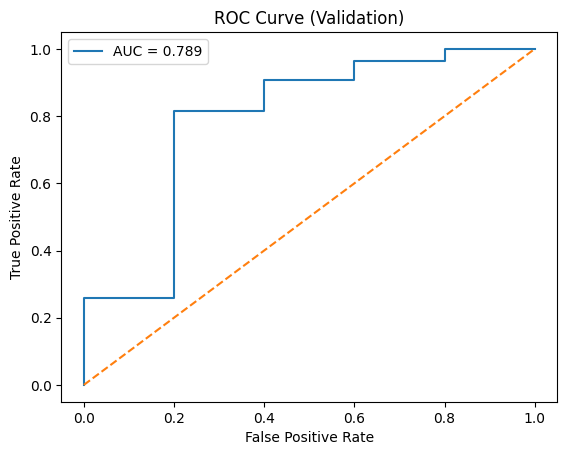

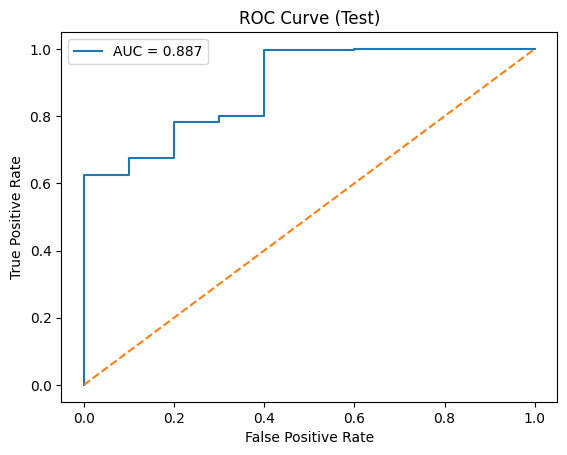

Validation Confusion Matrix (threshold = 0.1 ):\n [[  1   4]
 [  4 104]]
Test Confusion Matrix (threshold = 0.1 ):\n [[  6   4]
 [  8 208]]


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix

def collect_probs_and_labels(loader):
    model.eval()
    probs, gts = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device); y = y.to(device)
            logits = model(x)
            p = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            probs.append(p); gts.append(y.cpu().numpy())
    return np.concatenate(probs), np.concatenate(gts)

# Collect Validation
val_probs, val_gts = collect_probs_and_labels(val_loader)
# Collect Test
test_probs, test_gts = collect_probs_and_labels(test_loader)

# ROC for Validation
fpr_v, tpr_v, _ = roc_curve(val_gts, val_probs)
roc_auc_v = auc(fpr_v, tpr_v)
plt.figure()
plt.plot(fpr_v, tpr_v, label=f"AUC = {roc_auc_v:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.show()

# ROC for Test
fpr_t, tpr_t, _ = roc_curve(test_gts, test_probs)
roc_auc_t = auc(fpr_t, tpr_t)
plt.figure()
plt.plot(fpr_t, tpr_t, label=f"AUC = {roc_auc_t:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()

# Confusion matrices at BEST_T threshold (picked on Validation during training)
val_preds = (val_probs >= BEST_T).astype(int)
test_preds = (test_probs >= BEST_T).astype(int)
print("Validation Confusion Matrix (threshold =", BEST_T, "):\\n", confusion_matrix(val_gts, val_preds))
print("Test Confusion Matrix (threshold =", BEST_T, "):\\n", confusion_matrix(test_gts, test_preds))


## Saving the model

## Saving Emergency Model

In [13]:
save_path = "/kaggle/working/honking_reinforcement_model.pth"   # change path/filename as needed
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to /kaggle/working/honking_reinforcement_model.pth


## Testing the model randomly

In [12]:

def predict_file(path):
    mf = process_audio_mfcc(path)           # [T, n_mfcc]
    tok = mfcc_to_tokens(mf)                # [T]
    tok = pad_or_crop_1d(tok, MAX_LEN, 0)   # [MAX_LEN]
    x = torch.tensor(tok, dtype=torch.long)[None].to(device)
    with torch.no_grad():
        p = torch.softmax(model(x), dim=1)[:,1].item()
    label = 1 if p >= BEST_T else 0
    return {"proba_siren": float(p), "pred_label": int(label), "threshold": float(BEST_T)}

# Example:
print(predict_file("/kaggle/input/honking-and-non-honking-data/Honking/Dataset/2-37806-B-40.wav"))
print(predict_file("/kaggle/input/honking-and-non-honking-data/Honking/Dataset/C_10_A_N7.wav"))



{'proba_siren': 0.0007048901170492172, 'pred_label': 0, 'threshold': 0.1}
{'proba_siren': 0.9977015852928162, 'pred_label': 1, 'threshold': 0.1}


## Reinforcement Learning

In [14]:

# ==== RL Parameters ====
CHUNK_LEN = 128          # number of tokens per step
CHUNK_HOP = 64           # hop between steps
CONF_HIGH = 0.8          # high-confidence siren prob threshold
NOISE_RMS_HIGH = 0.05    # RMS threshold for high noise
SHORT_DURATION_STEPS = 3 # steps considered "short duration"

# Reward magnitudes
REWARD_ALERT_SIREN_HIGH = 10.0   # S (correct + high conf) and D (early alert)
REWARD_ALERT_SIREN_LOW  = -5.0   # S (wrong/low conf)
REWARD_ALERT_DELAYED    = -1.0   # S/D (delayed alert or delayed while confident siren)
REWARD_NOISE_HIGH       = -1.0   # N (penalize alert in high noise)
REWARD_NOISE_LOW_ALERT  = 0.5    # N (small reward for alert in low noise)
REWARD_OTHERWISE        = 1.0    # small shaping reward
REWARD_MISS_SIREN       = -5.0   # A (missed siren at episode end)

GAMMA = 0.99
TOTAL_TIMESTEPS = 50_000
SEED = 42

import os, numpy as np
from pathlib import Path
import gymnasium as gym
from gymnasium import spaces
import torch
import librosa
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

required = ["model","BEST_T","process_audio_mfcc","mfcc_to_tokens","pad_or_crop_1d","MAX_LEN","device"]
missing = [r for r in required if r not in globals()]
if missing:
    print("WARNING: Missing classifier globals:", missing)
else:
    print("Classifier globals found. Proceeding with RL.")


2025-09-11 01:01:36.489796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757552496.759555      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757552496.843455      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Classifier globals found. Proceeding with RL.


## Ensuring if the data and splitting exist or not

In [15]:
def infer_label_from_path(path):
    p = Path(path)
    name = p.name.lower()
    parent = p.parent.name.lower()
    return 1 if "ambulance" in name or "ambulance" in parent else 0

# Ensure wav_paths and splits exist (fallback uses the same DATA_DIR defined above)
if "wav_paths" not in globals():
    wav_paths = []
    for root, _, files in os.walk(DATA_DIR):
        for f in files:
            if f.lower().endswith(".wav"):
                wav_paths.append(os.path.join(root, f))
    wav_paths = sorted(wav_paths)
    print("Scanned wav_paths:", len(wav_paths))

from sklearn.model_selection import train_test_split
import numpy as np
labels_all = np.array([infer_label_from_path(p) for p in wav_paths])
if "train_idx" not in globals() or "val_idx" not in globals() or "test_idx" not in globals():
    idx = np.arange(len(wav_paths))
    train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=SEED, stratify=labels_all)
    train_idx, val_idx  = train_test_split(train_idx, test_size=0.125, random_state=SEED, stratify=labels_all[train_idx])
    print("Created splits (fallback):", len(train_idx), len(val_idx), len(test_idx))
else:
    print("Using existing train/val/test indices.")


Using existing train/val/test indices.


## Reward policy

In [16]:
class SirenChunkEnv(gym.Env):
    metadata = {"render_modes": []}
    def __init__(self, file_indices, wav_list,
                 chunk_len=CHUNK_LEN, chunk_hop=CHUNK_HOP,
                 conf_high=CONF_HIGH, noise_rms_high=NOISE_RMS_HIGH,
                 short_steps=SHORT_DURATION_STEPS):
        super().__init__()
        self.wav_list = wav_list
        self.file_indices = list(map(int, file_indices))
        self.chunk_len = chunk_len
        self.chunk_hop = chunk_hop
        self.conf_high = conf_high
        self.noise_rms_high = noise_rms_high
        self.short_steps = short_steps

        self.observation_space = spaces.Box(low=0, high=MAX_LEN, shape=(self.chunk_len,), dtype=np.int64)
        self.action_space = spaces.Discrete(2)  # 0: no alert, 1: alert

        self.cur_file = None
        self.cur_tokens = None
        self.cur_audio = None
        self.cur_label = None
        self.pos = 0
        self.steps_since_reset = 0

    def _file_to_tokens_and_audio(self, path):
        mf = process_audio_mfcc(path)        # [T, n_mfcc]
        toks = mfcc_to_tokens(mf)            # [T]
        y, _ = librosa.load(path, sr=SR if 'SR' in globals() else 16000)
        return toks, y

    def _get_window(self):
        start = self.pos
        end = min(start + self.chunk_len, len(self.cur_tokens))
        window = self.cur_tokens[start:end]
        if len(window) < self.chunk_len:
            window = pad_or_crop_1d(window, self.chunk_len, 0)
        return window

    def _window_rms(self):
        if self.cur_audio is None or len(self.cur_audio) == 0:
            return 0.0
        total_tokens = max(len(self.cur_tokens), 1)
        total_samples = len(self.cur_audio)
        start_tok = self.pos
        end_tok = min(self.pos + self.chunk_len, total_tokens)
        start_s = int(start_tok / total_tokens * total_samples)
        end_s   = int(end_tok   / total_tokens * total_samples)
        end_s   = max(end_s, start_s+1)
        seg = self.cur_audio[start_s:end_s]
        return float(np.sqrt(np.mean(seg**2)))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        rng = np.random.default_rng(seed if seed is not None else None)
        idx = rng.choice(self.file_indices)
        self.cur_file = self.wav_list[int(idx)]
        self.cur_tokens, self.cur_audio = self._file_to_tokens_and_audio(self.cur_file)
        self.cur_label = infer_label_from_path(self.cur_file)
        self.pos = 0
        self.steps_since_reset = 0
        obs = self._get_window().astype(np.int64)
        return obs, {}

    def step(self, action):
        done = False
        reward = 0.0

        window = self._get_window()
        x = torch.tensor(window, dtype=torch.long, device=device)[None]
        with torch.no_grad():
            prob_siren = torch.softmax(model(x), dim=1)[:,1].item()

        # S: Siren condition
        if action == 1:
            if self.cur_label == 1 and prob_siren >= self.conf_high:
                reward += REWARD_ALERT_SIREN_HIGH
            elif self.cur_label == 0:
                reward += 0.0
            else:
                reward += REWARD_ALERT_SIREN_LOW
        else:
            if self.cur_label == 1 and prob_siren >= BEST_T:
                reward += REWARD_ALERT_DELAYED
            else:
                reward += REWARD_OTHERWISE

        # N: Noise condition
        rms = self._window_rms()
        if action == 1 and rms >= self.noise_rms_high:
            reward += REWARD_NOISE_HIGH
        elif action == 1 and rms < self.noise_rms_high:
            reward += REWARD_NOISE_LOW_ALERT
        else:
            reward += REWARD_OTHERWISE

        # D: Duration condition
        if action == 1:
            if self.steps_since_reset <= self.short_steps:
                reward += REWARD_ALERT_SIREN_HIGH
            else:
                reward += REWARD_ALERT_DELAYED
            done = True  # alert ends the episode

        # progress
        self.pos += self.chunk_hop
        self.steps_since_reset += 1

        # A: Missed siren if end reached with no alert
        if self.pos >= len(self.cur_tokens):
            done = True
            if action == 0 and self.cur_label == 1:
                reward += REWARD_MISS_SIREN

        obs = self._get_window().astype(np.int64)
        return obs, float(reward), done, False, {"prob_siren": prob_siren, "rms": rms, "file": self.cur_file}


## Training of the agent

In [ ]:
# Vectorized envs
train_env = DummyVecEnv([lambda: SirenChunkEnv(train_idx, wav_paths)])
val_env   = DummyVecEnv([lambda: SirenChunkEnv(val_idx,   wav_paths)])

dqn = DQN(
    "MlpPolicy", train_env,
    learning_rate=1e-3, buffer_size=50_000, learning_starts=1_000,
    batch_size=64, gamma=GAMMA, train_freq=4, target_update_interval=1_000,
    exploration_fraction=0.2, exploration_final_eps=0.05,
    verbose=1, seed=SEED, tensorboard_log=None
)

dqn.learn(total_timesteps=TOTAL_TIMESTEPS)
dqn.save("honk_dqn_agent_v2")
print("Saved DQN agent to honk_dqn_agent_v2.zip")


Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 53       |
|    time_elapsed     | 0        |
|    total_timesteps  | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 63       |
|    time_elapsed     | 0        |
|    total_timesteps  | 8        |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 66       |
|    time_elapsed     | 0        |
|    total_timesteps  | 12       |
----------------------------------
----------------------------------
| 

## Evaluation of DQN Agent

In [ ]:
test_env = DummyVecEnv([lambda: SirenChunkEnv(test_idx, wav_paths)])
mean_r, std_r = evaluate_policy(dqn, test_env, n_eval_episodes=50, deterministic=True)
print(f"Evaluation over 50 episodes — mean reward: {mean_r:.2f} ± {std_r:.2f}")

# One rollout (deterministic)
env = SirenChunkEnv(test_idx, wav_paths)
obs, _ = env.reset()
terminated = truncated = False
steps = 0
cum_r = 0.0
from pathlib import Path
while not (terminated or truncated):
    action, _ = dqn.predict(obs, deterministic=True)
    obs, r, terminated, truncated, info = env.step(int(action))
    steps += 1
    cum_r += r
    if action == 1:
        print(f"[STEP {steps}] ALERT | prob={info['prob_siren']:.3f} | rms={info['rms']:.4f} | r={r:.2f} | file={Path(info['file']).name}")
    else:
        print(f"[STEP {steps}] no alert | prob={info['prob_siren']:.3f} | rms={info['rms']:.4f} | r={r:.2f}")
print("Episode done. Total reward:", cum_r)


## Evaluating the Agent over 200 episodes and generating a learning curve

In [ ]:
from gymnasium import spaces
import numpy as np, torch, librosa

class SirenChunkEnvV2(SirenChunkEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # episode accumulators
        self._ep_return = 0.0
        self._ep_len = 0
        self._ep_s = 0.0
        self._ep_n = 0.0
        self._ep_d = 0.0
        self._ep_a = 0.0

    def reset(self, seed=None, options=None):
        obs, info = super().reset(seed=seed, options=options)
        self._ep_return = 0.0
        self._ep_len = 0
        self._ep_s = 0.0
        self._ep_n = 0.0
        self._ep_d = 0.0
        self._ep_a = 0.0
        return obs, info

    def step(self, action):
        done = False
        info = {}

        # --- compute components (S, N, D, A) separately ---
        # classifier probability
        window = self._get_window()
        x = torch.tensor(window, dtype=torch.long, device=device)[None]
        with torch.no_grad():
            prob_siren = torch.softmax(model(x), dim=1)[:,1].item()

        # S: siren correctness/confidence
        s_r = 0.0
        if action == 1:
            if self.cur_label == 1 and prob_siren >= self.conf_high:
                s_r += REWARD_ALERT_SIREN_HIGH
            elif self.cur_label == 0:
                s_r += 0.0
            else:
                s_r += REWARD_ALERT_SIREN_LOW
        else:
            if self.cur_label == 1 and prob_siren >= BEST_T:
                s_r += REWARD_ALERT_DELAYED
            else:
                s_r += REWARD_OTHERWISE

        # N: noise effect
        rms = self._window_rms()
        n_r = 0.0
        if action == 1 and rms >= self.noise_rms_high:
            n_r += REWARD_NOISE_HIGH
        elif action == 1 and rms < self.noise_rms_high:
            n_r += REWARD_NOISE_LOW_ALERT
        else:
            n_r += REWARD_OTHERWISE

        # D: timeliness
        d_r = 0.0
        if action == 1:
            if self.steps_since_reset <= self.short_steps:
                d_r += REWARD_ALERT_SIREN_HIGH
            else:
                d_r += REWARD_ALERT_DELAYED
            done = True  # episode ends on alert

        # Progress
        self.pos += self.chunk_hop
        self.steps_since_reset += 1

        # A: missed siren at end
        a_r = 0.0
        if self.pos >= len(self.cur_tokens):
            done = True
            if action == 0 and self.cur_label == 1:
                a_r += REWARD_MISS_SIREN

        reward = float(s_r + n_r + d_r + a_r)

        # Update accumulators
        self._ep_return += reward
        self._ep_len += 1
        self._ep_s += s_r
        self._ep_n += n_r
        self._ep_d += d_r
        self._ep_a += a_r

        obs = self._get_window().astype(np.int64)
        info.update({
            "prob_siren": prob_siren,
            "rms": rms,
            "file": self.cur_file
        })
        if done:
            info.update({
                "episode_return": self._ep_return,
                "episode_length": self._ep_len,
                "ep_s": self._ep_s,
                "ep_n": self._ep_n,
                "ep_d": self._ep_d,
                "ep_a": self._ep_a,
                "label": int(self.cur_label),
            })
        return obs, reward, done, False, info

In [ ]:
from stable_baselines3.common.callbacks import BaseCallback

class EpisodeStatsCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_returns = []
        self.episode_lengths = []
        self.ep_s = []
        self.ep_n = []
        self.ep_d = []
        self.ep_a = []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        for info in infos:
            if "episode_return" in info:  # episode finished for this env
                self.episode_returns.append(info["episode_return"])
                self.episode_lengths.append(info["episode_length"])
                self.ep_s.append(info.get("ep_s", 0.0))
                self.ep_n.append(info.get("ep_n", 0.0))
                self.ep_d.append(info.get("ep_d", 0.0))
                self.ep_a.append(info.get("ep_a", 0.0))
        return True

stats_cb = EpisodeStatsCallback()

In [21]:
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv

log_train_env = DummyVecEnv([lambda: SirenChunkEnvV2(train_idx, wav_paths)])
dqn_log = DQN(
    "MlpPolicy", log_train_env,
    learning_rate=1e-3, buffer_size=50_000, learning_starts=1_000,
    batch_size=64, gamma=GAMMA, train_freq=4, target_update_interval=1_000,
    exploration_fraction=0.2, exploration_final_eps=0.05,
    verbose=0, seed=SEED, tensorboard_log=None
)

# warm-start from the previously trained agent if available
try:
    dqn_log.load("siren_dqn_agent_v2", env=log_train_env)
    print("Loaded weights from siren_dqn_agent_v2.zip")
except Exception as e:
    print("Fresh RL training (no prior agent found):", e)

# Train a bit more to gather stats (adjust timesteps as needed)
ADDITIONAL_TIMESTEPS = 20_000
dqn_log.learn(total_timesteps=ADDITIONAL_TIMESTEPS, callback=stats_cb)
print(f"Collected {len(stats_cb.episode_returns)} episodes during logging run.")

Collected 20000 episodes during logging run.


## Plotting the learning curve

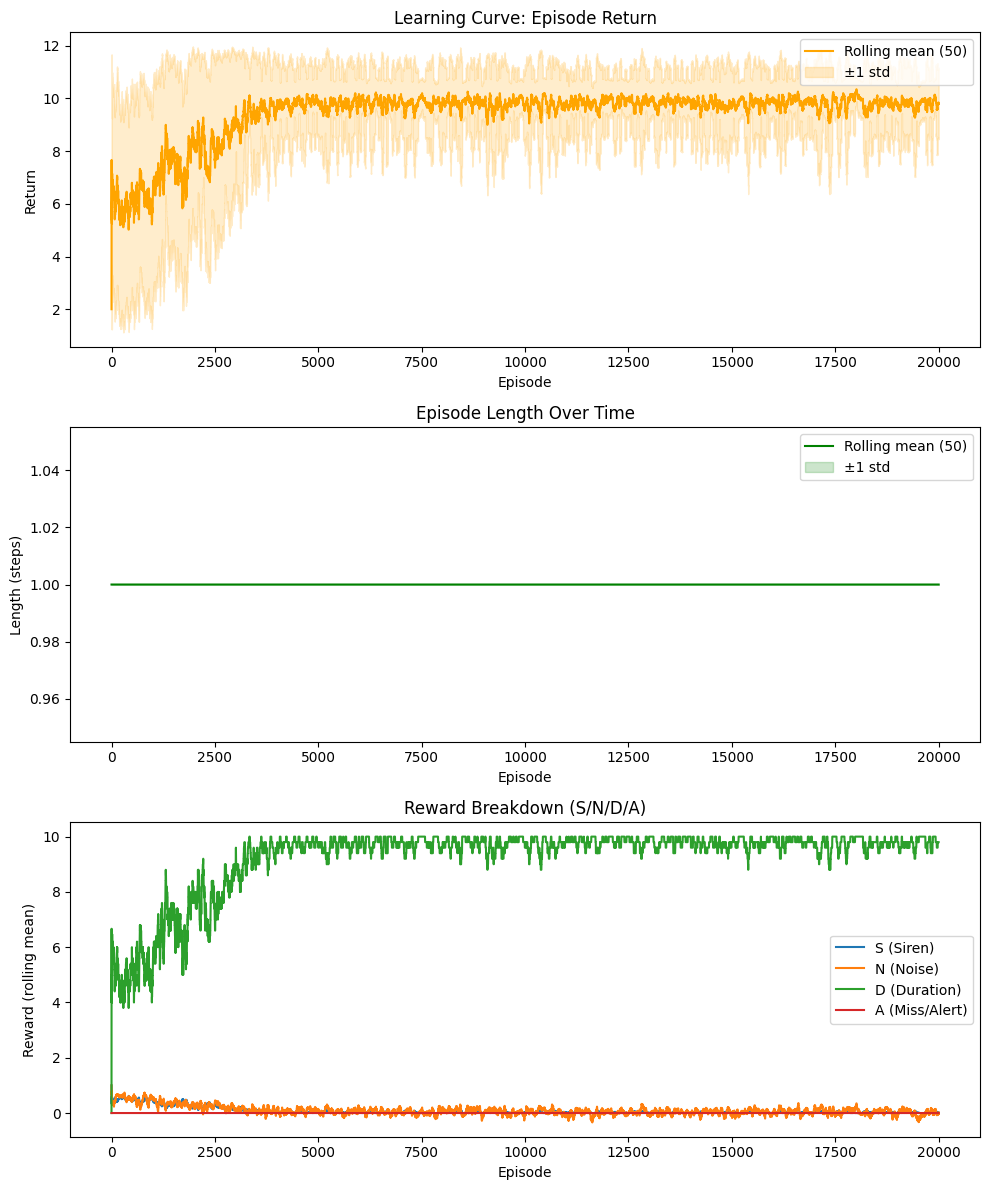

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def rolling_stats(x, window=50):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return np.array([]), np.array([])
    means, stds = [], []
    for i in range(len(x)):
        lo = max(0, i - window + 1)
        seg = x[lo:i+1]
        means.append(np.mean(seg))
        stds.append(np.std(seg))
    return np.array(means), np.array(stds)

fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# 1) Learning curve (only smoothed)
ret = stats_cb.episode_returns
m, s = rolling_stats(ret, window=50)
axs[0].plot(m, label="Rolling mean (50)", color="orange")
axs[0].fill_between(np.arange(len(m)), m - s, m + s, alpha=0.2, color="orange", label="±1 std")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Return")
axs[0].set_title("Learning Curve: Episode Return")
axs[0].legend()

# 2) Episode length (only smoothed)
elens = stats_cb.episode_lengths
mL, sL = rolling_stats(elens, window=50)
axs[1].plot(mL, label="Rolling mean (50)", color="green")
axs[1].fill_between(np.arange(len(mL)), mL - sL, mL + sL, alpha=0.2, color="green", label="±1 std")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length (steps)")
axs[1].set_title("Episode Length Over Time")
axs[1].legend()

# 3) Reward breakdown (S/N/D/A, smoothed only)
s_m, _ = rolling_stats(stats_cb.ep_s, window=50)
n_m, _ = rolling_stats(stats_cb.ep_n, window=50)
d_m, _ = rolling_stats(stats_cb.ep_d, window=50)
a_m, _ = rolling_stats(stats_cb.ep_a, window=50)
axs[2].plot(s_m, label="S (Siren)")
axs[2].plot(n_m, label="N (Noise)")
axs[2].plot(d_m, label="D (Duration)")
axs[2].plot(a_m, label="A (Miss/Alert)")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Reward (rolling mean)")
axs[2].set_title("Reward Breakdown (S/N/D/A)")
axs[2].legend()

plt.tight_layout()
plt.show()


## Saving the Emergency siren AGENT

In [ ]:
# Save the DQN agent
dqn_save_path = "/kaggle/working/emergency_siren_dqn_agent"
dqn.save(dqn_save_path)
print(f"DQN agent saved to {dqn_save_path}.zip")